In [1]:
from alpdesign.utils import *
from alpdesign.mlp import *
from jax_unirep import get_reps
import alpdesign
import numpy as np
import matplotlib.pyplot as plt
import jax_unirep
import haiku as hk
import jax
import jax.numpy as jnp
import functools
from sklearn.decomposition import PCA

In [2]:
AA_list = ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V','B','Z','X','*']
blosum92 = np.loadtxt("./blosum62.txt", dtype='i', delimiter=' ')
print(blosum92)

[[ 4 -1 -2 -2  0 -1 -1  0 -2 -1 -1 -1 -1 -2 -1  1  0 -3 -2  0 -2 -1  0 -4]
 [-1  5  0 -2 -3  1  0 -2  0 -3 -2  2 -1 -3 -2 -1 -1 -3 -2 -3 -1  0 -1 -4]
 [-2  0  6  1 -3  0  0  0  1 -3 -3  0 -2 -3 -2  1  0 -4 -2 -3  3  0 -1 -4]
 [-2 -2  1  6 -3  0  2 -1 -1 -3 -4 -1 -3 -3 -1  0 -1 -4 -3 -3  4  1 -1 -4]
 [ 0 -3 -3 -3  9 -3 -4 -3 -3 -1 -1 -3 -1 -2 -3 -1 -1 -2 -2 -1 -3 -3 -2 -4]
 [-1  1  0  0 -3  5  2 -2  0 -3 -2  1  0 -3 -1  0 -1 -2 -1 -2  0  3 -1 -4]
 [-1  0  0  2 -4  2  5 -2  0 -3 -3  1 -2 -3 -1  0 -1 -3 -2 -2  1  4 -1 -4]
 [ 0 -2  0 -1 -3 -2 -2  6 -2 -4 -4 -2 -3 -3 -2  0 -2 -2 -3 -3 -1 -2 -1 -4]
 [-2  0  1 -1 -3  0  0 -2  8 -3 -3 -1 -2 -1 -2 -1 -2 -2  2 -3  0  0 -1 -4]
 [-1 -3 -3 -3 -1 -3 -3 -4 -3  4  2 -3  1  0 -3 -2 -1 -3 -1  3 -3 -3 -1 -4]
 [-1 -2 -3 -4 -1 -2 -3 -4 -3  2  4 -2  2  0 -3 -2 -1 -2 -1  1 -4 -3 -1 -4]
 [-1  2  0 -1 -3  1  1 -2 -1 -3 -2  5 -1 -3 -1  0 -1 -3 -2 -2  0  1 -1 -4]
 [-1 -1 -2 -3 -1  0 -2 -3 -2  1  2 -1  5  0 -2 -1 -1 -1 -1  1 -3 -1 -1 -4]
 [-2 -3 -3 -3 -2 -3 -3 -3

In [3]:
def blosum(seq1, seq2):
    seqlist1 = list(seq1)
    seqlist2 = list(seq2)
    score = 0.
    for i in range(len(seqlist1)):
        idx1 = AA_list.index(seqlist1[i])
        idx2 = AA_list.index(seqlist2[i])
        score += blosum92[idx1][idx2]
    return jax.nn.sigmoid(score/len(seqlist1))
    #return score/len(seqlist1)

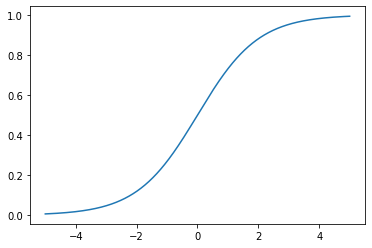

In [4]:
x = np.linspace(-5, 5, 1000)
y = jax.nn.sigmoid(x)
plt.plot(x, y)

In [5]:
#target_seq = 'GIGAVLKVLTTGLPALISWIKRKRQQSSVAAWRPPKL'
target_seq = 'HAPPYGIRLS'
oh_vec = encode_seq(list(target_seq))
oh_unirep = seq2useq(oh_vec)
target_rep = differentiable_jax_unirep(oh_unirep)
#print(target_rep.shape)

'''
seqs = [
    'AHKSQYFPDAYVFSEHDVGTYWGKFQCANFTNERLDC',
    'KPHFEDCDYMLPMQQIGLYCEKYCAFHSYWPWCFVSK',
    'AHWEWRMPWMSPLADDEYWDNGNDNPVKSGKLHPCDE',
    'ITACDQYLWGWMVTGFFDSGDMTDAMIANKHKWLFYV',
    'GDIGHQWGGFSWWHMWMCAVCQPVTKSMRRLTRSSTQ',
    'DFECGPQRTHVEPDKASSFFNPCLAVSMSTLFYAVNE',
    'GCHEYAATIEGHTDDCKPELDMWCHGLIGRYMQRYQP',
    'VHISALDSYVSGSNPRPQDYMMGPTRWCCYGCWVHYE',
    'ILMVIADVNMYVVQWEYYQMWRALHEFWAVPGKMCQM',
    'CNCWMKCCMPFLHEPSADLCSWPYWYNNWQLRQACRT'
]
'''

seqs = ['CNCWMKCCMP',
        'RPWTQRPDTM',
        'YFHQYLTSVR',
        'EGHIMMFMRM',
        'RSVWNNDEFV',
        'THQHTWALQA',
        'CNANVDGAEQ',
        'KLAMDCPNTF']
'''
seqs = ['RPWTQRPDTM','YFHQYLTSVR']
'''

reps = get_reps(seqs)[0]
labels = []
for seq in seqs:
    labels.append(blosum(target_seq, seq))
labels = np.array(labels)

print(labels)

val_seqs = ['ISLWPVIHSI',
            'INKGHVPSRL',
            'DRSVKGQDGV',
            'KIATCQIWET',
            'AKDKEAYDNT',
            'ATKQPRYICE',
            'YVQATECGEK',
            'YDAPWGRENW',
            'SKYDWNCDIE',
            'ENKLWNSSQP',
            'IPIRNMVFVL',
            'EAIAQKLKKQ',
            'FDCYIIMDAM',
            'EWAHKQLGPP',
            'FLNRCKYTGI']
'''
'NCPKEWAWSQ',
            'GVMVFLELEF',
            'PWVWVQSQDD',
            'KQWETDPIWK',
            'RMKMRQQLIL' ]

'''
            
val_reps = get_reps(seqs)[0]
val_labels = []
for val_seq in val_seqs:
    val_labels.append(blosum(target_seq, val_seq))
val_labels = np.array(val_labels)
print(val_labels)

[0.14185107 0.16798161 0.45016605 0.21416503 0.23147522 0.18242553
 0.14185107 0.15446526]
[0.18242553 0.15446526 0.23147522 0.2890505  0.23147522 0.19781612
 0.26894143 0.62245935 0.37754068 0.26894143 0.18242553 0.4750208
 0.15446526 0.19781612 0.14185107]


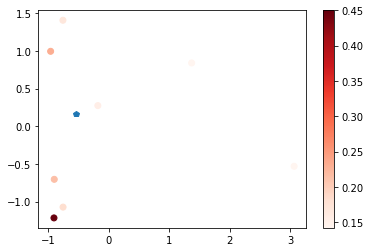

In [6]:
pca = PCA(n_components=2)
pca.fit(reps)
proj_x = pca.transform(reps)
plt.scatter(proj_x[:,0], proj_x[:,1], c=labels, cmap=plt.get_cmap('Reds'))
plt.colorbar()
proj_l = pca.transform(target_rep)
plt.plot(proj_l[:,0], proj_l[:,1], 'p')

In [7]:
key = jax.random.PRNGKey(0)
c = alpdesign.EnsembleBlockConfig()
forward_fxn, full_forward_fxn = alpdesign.build_model(c)
full_forward_t = hk.without_apply_rng(hk.transform(full_forward_fxn))

In [8]:
#params, losses = alpdesign.ensemble_train(
#    key, full_forward_t, c, reps, labels, epochs=50, learning_rate=2e-4)
forward_t = hk.without_apply_rng(hk.transform(forward_fxn))
#forward = functools.partial(forward_t.apply, params)
#plt.plot(losses)

In [9]:
# e2e is a haiku func
def e2e(params, logits): # params is trained mlp params
    s = alpdesign.SeqpropBlock()(logits)
    us = alpdesign.seq2useq(s)
    u = alpdesign.differentiable_jax_unirep(us)
    forward = functools.partial(forward_t.apply, params)
    return forward(u)
#e2e_t = hk.transform(e2e)
#init_logits = jax.random.normal(key, shape=((10, 20)))
#e2e_params = e2e_t.init(key, init_logits)

def e2e_fxn(e2e_t, x, key):
    e2e_params, logits = x
    yhat = e2e_t.apply(e2e_params, key, logits)
    return yhat

In [10]:
batch_size = 8
BO_batch_size = 32
reps = get_reps(seqs)[0]
labels = []
for seq in seqs:
    labels.append(blosum(target_seq, seq))
labels = np.array(labels)
def loop(key, reps, labels, params, rb=None):
    key, train_key = jax.random.split(key, num=2)
    params, mlp_loss, val_loss= alpdesign.ensemble_train(train_key, full_forward_t, c, reps, 
                                                         labels, val_seqs=val_reps, val_labels=val_labels, 
                                                         params=params, batch_size=batch_size, epochs=80, learning_rate=2e-4)
    # make random point
    init_logits = jax.random.normal(key, shape=((10, 20)))
    e2e_ = lambda logits: functools.partial(e2e, params)(logits)
    e2e_t = hk.transform(e2e_)
    key, train_key = jax.random.split(key, num=2)
    if rb is None:
        rb = e2e_t.init(key, init_logits)
    e2e_params = rb
    key, train_key = jax.random.split(key, num=2)
    init_x = 0.1*jax.random.normal(key, shape=(BO_batch_size, 10, 20))
    #forward = jax.vmap(lambda x, key: forward_t.apply(params, x), in_axes=(0, None))
    print('start BO')
    #batch_e2e = jax.vmap(lambda x, key: functools.partial(e2e_fxn, e2e_t)(params, x), in_axes=((None, 0), None))
    batch_e2e = jax.vmap(functools.partial(e2e_fxn, e2e_t), ((None, 0), None), (0, 0))
    #batched_x, bo_losses = alpdesign.mlp.bayes_opt(key, batch_e2e, labels, (e2e_t.init(train_key, init_logits), init_x), epsilon=0.01, iter_num=500)
    batched_x, bo_losses = alpdesign.mlp.bayes_opt(key, batch_e2e, labels, (e2e_params, init_x), epsilon=0.01, iter_num=500, learning_rate=1e-2)
    top_idx = np.argmin(bo_losses[-1])
    rb = batched_x[0]
    batched_logits = batched_x[1]
    final_logits = batched_logits[top_idx]
    bo_losses = jnp.array(bo_losses)
    bo_loss = bo_losses[...,top_idx]
    vec = alpdesign.seq.forward_seqprop.apply(rb, key, final_logits)
    s = decode_seq(vec)
    reps = np.concatenate((reps, get_reps([s])[0]))
    
    y = blosum(target_seq, s)
    print(reps.shape)
    print(s, y)
    labels = np.concatenate((labels, np.array(y).reshape(1,)))
    '''
    plt.figure()
    proj_x = pca.transform(reps)
    #print(proj_x)
    plt.scatter(proj_x[:,0], proj_x[:,1], c=labels, cmap=plt.get_cmap('Reds'))
    plt.colorbar()
    proj_l = pca.transform(target_rep)
    plt.plot(proj_l[:,0], proj_l[:,1], 'p')
    plt.plot(proj_x[-1, 0], proj_x[-1, 1], 'o', color='green')    
    plt.show()
    
    '''
    return key, reps, labels, s, params, rb, bo_loss, mlp_loss, val_loss
    

    

0
start BO
(9, 1900)
['Y', 'F', 'H', 'H', 'Y', 'F', 'H', 'Y', 'Y', 'Y'] 0.31002554


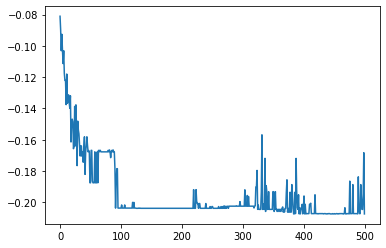

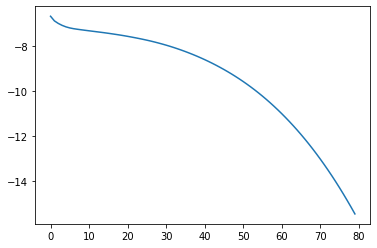

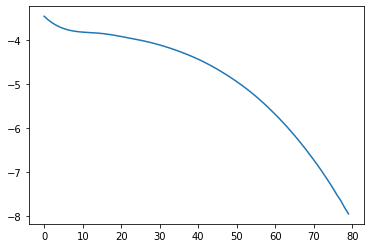

1
start BO
(10, 1900)
['Y', 'F', 'H', 'Y', 'F', 'L', 'S', 'I', 'Y', 'R'] 0.21416503


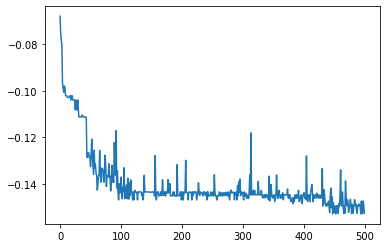

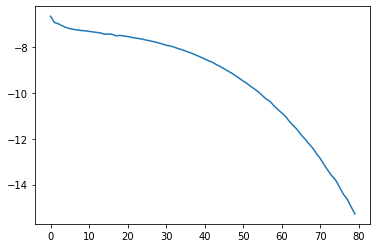

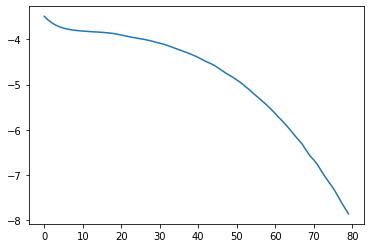

2
start BO
(11, 1900)
['Y', 'F', 'H', 'Q', 'F', 'F', 'H', 'H', 'I', 'A'] 0.4255575


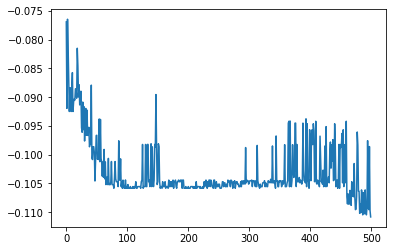

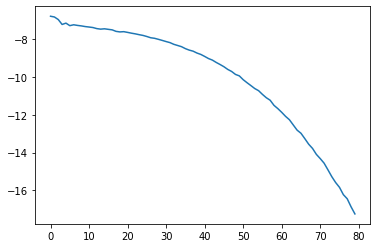

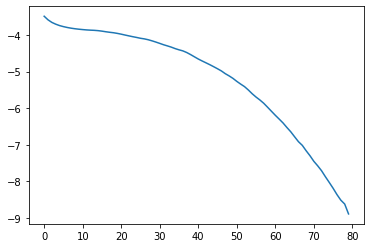

3
start BO
(12, 1900)
['Q', 'F', 'H', 'Q', 'F', 'F', 'H', 'Q', 'L', 'H'] 0.40131235


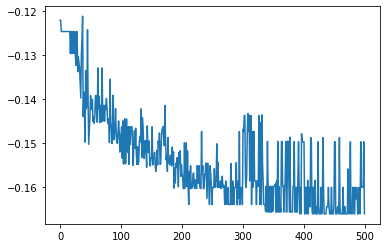

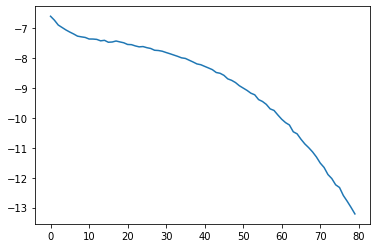

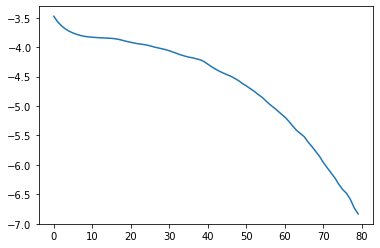

4
start BO
(13, 1900)
['K', 'F', 'H', 'Q', 'Q', 'F', 'H', 'H', 'F', 'H'] 0.19781612


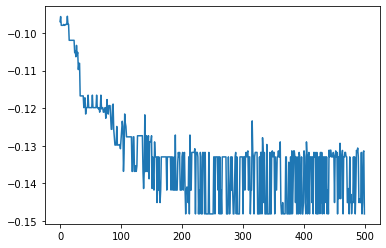

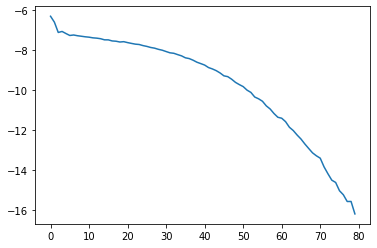

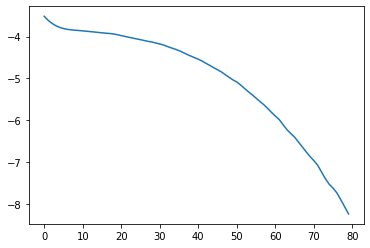

5
start BO
(14, 1900)
['F', 'F', 'H', 'Q', 'F', 'F', 'H', 'N', 'L', 'H'] 0.35434368


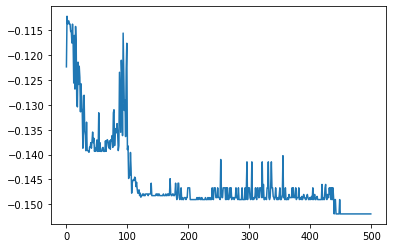

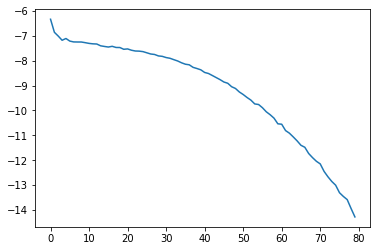

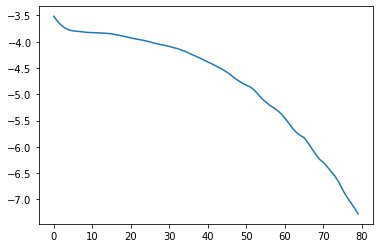

6
start BO
(15, 1900)
['F', 'F', 'H', 'R', 'L', 'F', 'H', 'E', 'L', 'H'] 0.24973992


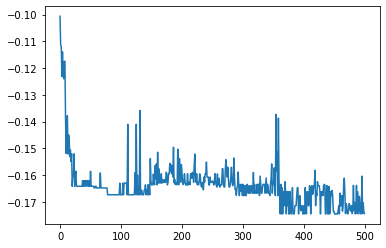

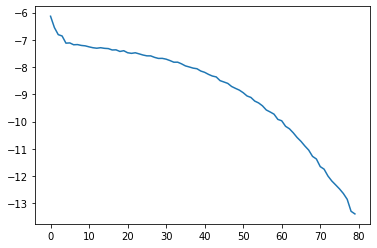

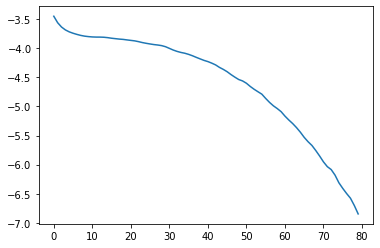

7
start BO
(16, 1900)
['F', 'F', 'H', 'Q', 'F', 'H', 'Q', 'F', 'F', 'Q'] 0.24973992


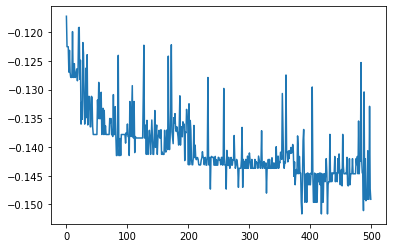

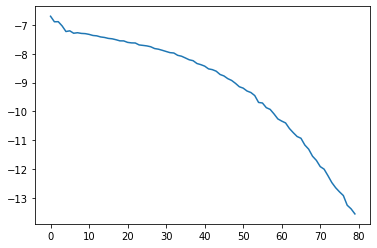

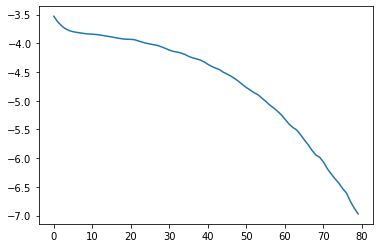

8
start BO
(17, 1900)
['Y', 'F', 'H', 'Q', 'Y', 'L', 'Q', 'T', 'I', 'T'] 0.4750208


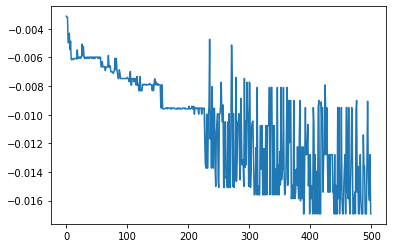

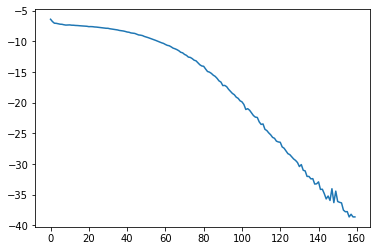

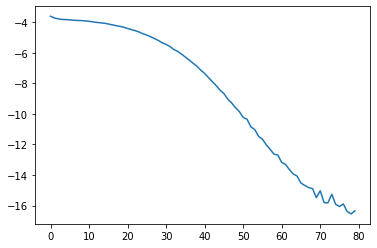

9
start BO
(18, 1900)
['H', 'Y', 'L', 'N', 'Q', 'I', 'T', 'Q', 'T', 'I'] 0.3318122


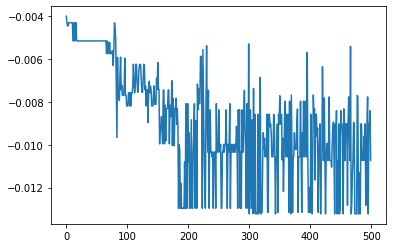

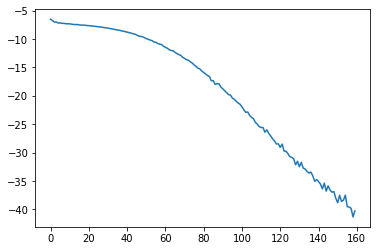

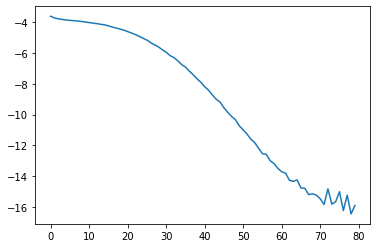

10
start BO
(19, 1900)
['L', 'Q', 'Q', 'Q', 'L', 'Q', 'Q', 'M', 'I', 'T'] 0.26894143


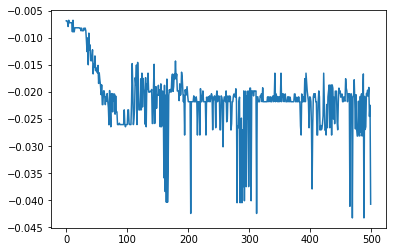

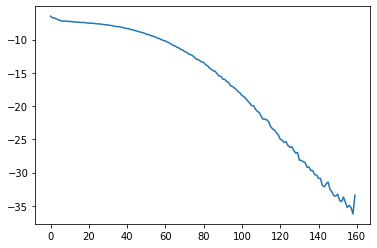

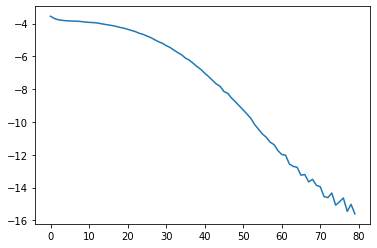

11
start BO
(20, 1900)
['N', 'F', 'N', 'N', 'F', 'I', 'N', 'N', 'S', 'T'] 0.26894143


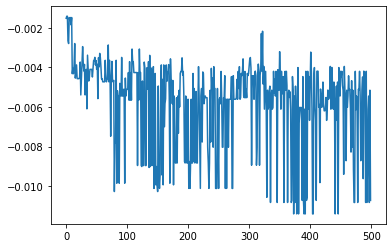

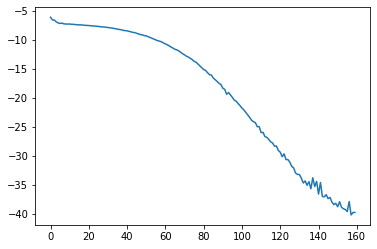

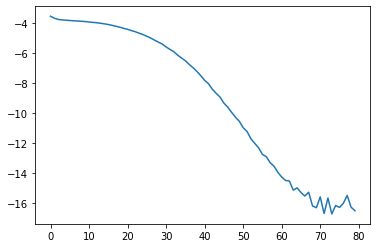

12
start BO
(21, 1900)
['H', 'Y', 'H', 'Q', 'Y', 'L', 'T', 'Q', 'L', 'I'] 0.6899745


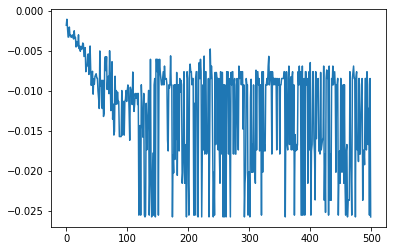

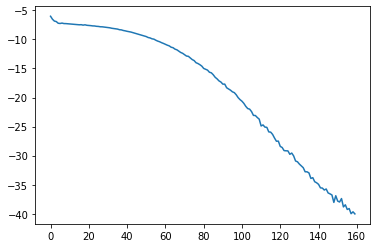

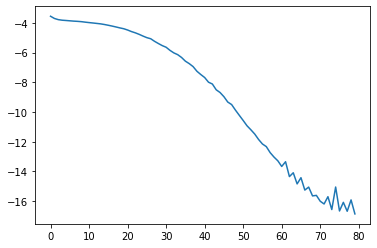

13
start BO
(22, 1900)
['H', 'H', 'H', 'Q', 'Y', 'Q', 'Y', 'Q', 'L', 'L'] 0.73105854


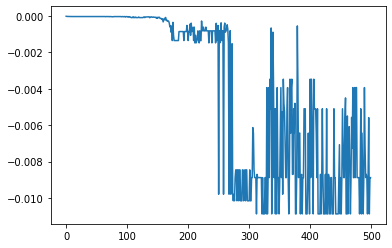

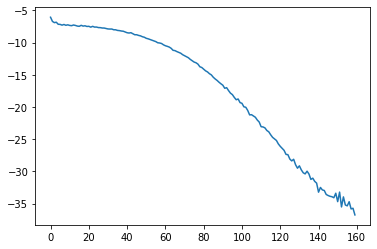

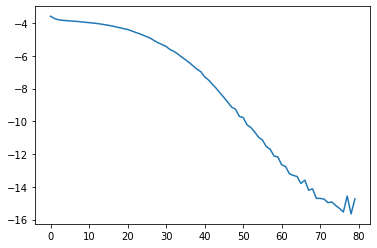

14
start BO
(23, 1900)
['H', 'H', 'H', 'H', 'Q', 'Y', 'Q', 'H', 'Q', 'L'] 0.2890505


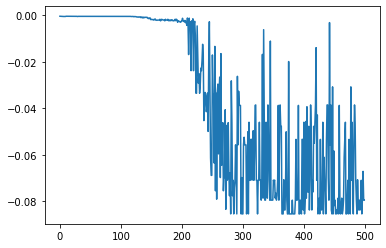

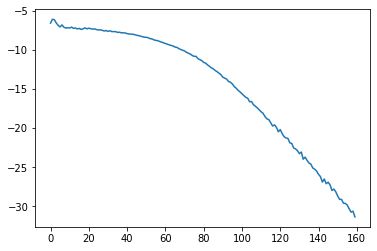

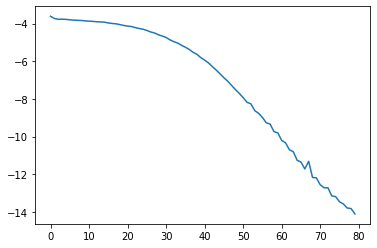

15
start BO
(24, 1900)
['H', 'Y', 'Y', 'Q', 'W', 'Y', 'M', 'Q', 'L', 'M'] 0.6456563


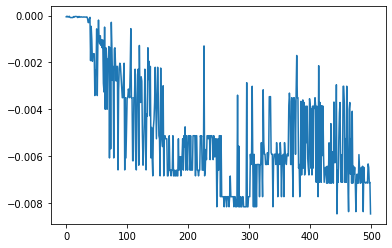

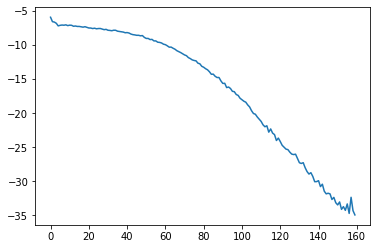

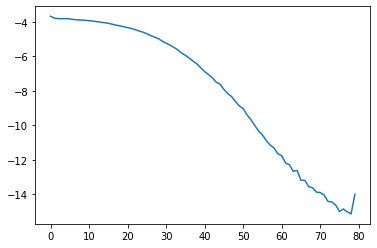

16
start BO
(25, 1900)
['Y', 'S', 'L', 'Y', 'W', 'K', 'Q', 'F', 'Y', 'G'] 0.26894143


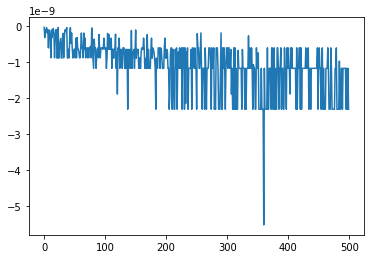

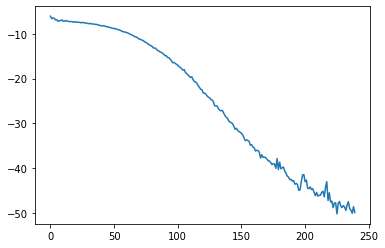

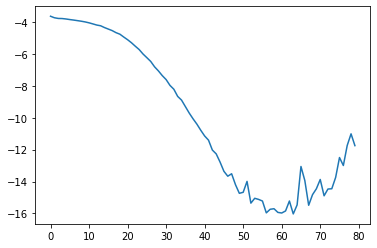

17
start BO
(26, 1900)
['H', 'Y', 'Q', 'Y', 'Y', 'Q', 'W', 'Y', 'M', 'L'] 0.54983395


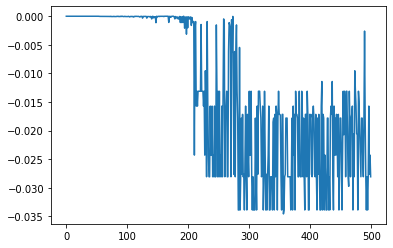

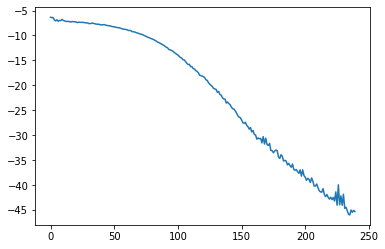

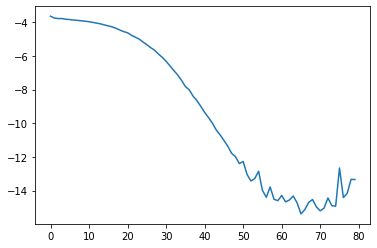

18
start BO
(27, 1900)
['M', 'I', 'I', 'G', 'C', 'D', 'G', 'W', 'R', 'Q'] 0.11920293


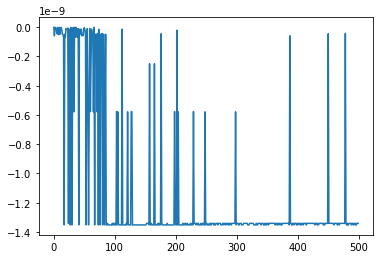

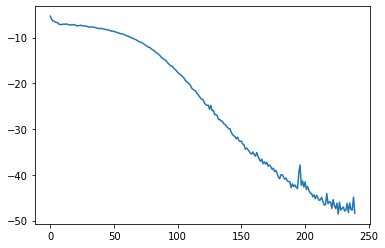

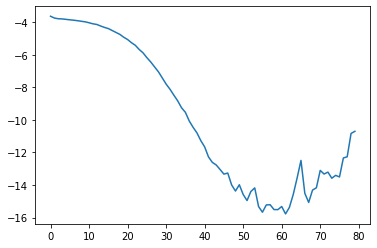

19
start BO
(28, 1900)
['C', 'Y', 'Y', 'Q', 'E', 'Q', 'Y', 'L', 'F', 'A'] 0.18242553


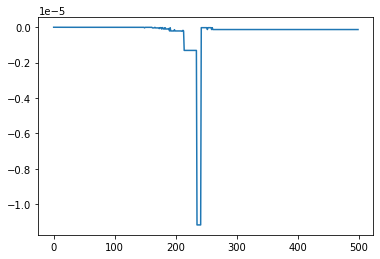

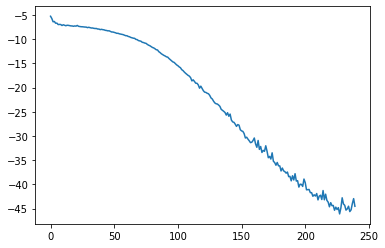

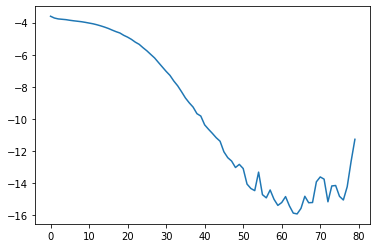

In [11]:
key = jax.random.PRNGKey(0)
params = None
rb = None
for i in range(20):
    print(i)
    rb = None
    params = None
    key, _ = jax.random.split(key, num=2)
    key, reps, labels, final_vec, params, rb, bo_loss, mlp_loss, val_loss= loop(key, reps, labels, params, rb)
    plt.figure()
    plt.plot(bo_loss)
    plt.show()
    plt.figure()
    plt.plot(mlp_loss)
    plt.show()
    plt.figure()
    plt.plot(val_loss)
    plt.show()
    #print(final_vec)

In [ ]:
['GIGAVLKILIAAARPREAITAALKKR']
['GIGAVLKVLTTGLPALISWIKRKRQQ']